In [1]:
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
import pickle

sys.path.append(os.path.join(os.path.abspath("..")))
from src.models import PopularityRecommender, MatrixFactorizationRecommender
from src.visualization import plot_learning_curve

### Load train set và test set

In [2]:
PROCESSED_FOLDER = "../data/processed"
train_data = np.load(os.path.join(PROCESSED_FOLDER, "train_data.npy"))
test_data = np.load(os.path.join(PROCESSED_FOLDER, "test_data.npy"))

In [3]:
with open(os.path.join(PROCESSED_FOLDER, "user_map.pkl"), "rb") as f:
    user_map = pickle.load(f)
with open(os.path.join(PROCESSED_FOLDER, "product_map.pkl"), "rb") as f:
    product_map = pickle.load(f)

### Inverse Mapping

In [4]:
inv_user_map = {v: k for k, v in user_map.items()}
inv_product_map = {v: k for k, v in product_map.items()}

### Check data

In [5]:
print(f"Train Data Shape: {train_data.shape}")
print(f"Test Data Shape:  {test_data.shape}")
print(f"Total Users: {len(user_map)}")
print(f"Total Items: {len(product_map)}")

Train Data Shape: (158801, 6)
Test Data Shape:  (39701, 6)
Total Users: 22363
Total Items: 12101


In [6]:
n_users = len(user_map)
n_products = len(product_map)

### Popularity Recommender model
1. **Tổng quan**\
Đây là mô hình gợi ý đơn giản và cơ bản nhất (Baseline Model). Mô hình tính toán điểm đánh giá trung bình cho từng sản phẩm dựa trên toàn bộ dữ liệu huấn luyện. Mô hình mang tính phi cá nhân hóa, tức là danh sách gợi ý sẽ giống hệt nhau đối với tất cả người dùng, hệ thống sẽ gợi ý những sản phẩm có điểm trung bình cao nhất.
2. **Mục đích sử dụng**\
Mô hình này dùng để thiết lập mốc chuẩn để so sánh với mô hình tốt hơn là Matrix Factorization. Ngoài ra mô hình còn giải quyết vấn đề **Cold Start**. Đối với những người dùng mới chưa có lịch sử tương tác, mô hình Matrix Factorization không thể tính toán sở thích cá nhân. Trong trường hợp đó, gợi ý những sản phẩm Top Rated là chiến lược an toàn và hiệu quả nhất.

In [7]:
pop_model = PopularityRecommender()
pop_model.fit(train_data)

In [8]:
baseline_rmse = pop_model.evaluate(test_data)
print(f"Baseline RMSE (Popularity): {baseline_rmse:.4f}")

Baseline RMSE (Popularity): 1.0085


### MatrixFactorizationRecommender model
1. **Tổng quan:** Mô hình này thuộc nhóm giải thuật Lọc cộng tác (Collaborative Filtering) và đóng vai trò là trái tim của hệ thống gợi ý trong dự án này.
  - **Nguyên lý hoạt động:** Mô hình giả định rằng sở thích của người dùng và đặc tính của sản phẩm không phải là ngẫu nhiên, mà được chi phối bởi một số ít các nhân tố ẩn (Latent Factors).
  - **Cơ chế toán học:** Chúng ta phân rã ma trận tương tác Người dùng - Sản phẩm (User-Product Matrix) vốn rất thưa thớt ($R$) thành tích của hai ma trận đặc trưng có kích thước nhỏ hơn:
    - User Matrix ($P$): Biểu diễn đặc trưng ẩn của người dùng (ví dụ: độ nhạy cảm về giá, gu thẩm mỹ...).
    - Product Matrix ($Q$): Biểu diễn đặc trưng ẩn của sản phẩm (ví dụ: độ bền, thương hiệu...).
    - Dự đoán: Ma trận xếp hạng xấp xỉ được tái tạo bằng công thức: $\hat{R} \approx P \times Q^T$.

2. **Mục đích**
  - **Cá nhân hóa Tối đa:**
    - Khác với mô hình Popularity, MF có khả năng học được sở thích riêng của từng khách hàng.
    - Thông qua việc học các vector đặc trưng ($P_u$ và $Q_i$), mô hình có thể dự đoán được sự yêu thích của User A đối với Product B ngay cả khi họ chưa từng tương tác, dựa trên sự tương đồng về hành vi với những người dùng khác.
  - **Xử lý Độ thưa & Điền khuyết:**
    - Với độ thưa dữ liệu lên tới >99.99%, hầu hết các ô trong ma trận đều trống. MF là công cụ mạnh mẽ nhất để suy luận và dự đoán giá trị cho hàng triệu ô trống đó, giúp hệ thống có thể đưa ra gợi ý cho bất kỳ cặp User-Product nào.

3. **Công thức Dự đoán**\
Điểm số dự đoán ($\hat{r}_{ui}$) cho User $u$ và Item $i$ được tính bằng:
    $$
    \hat{r}_{ui} = \mu + b_u + b_i + \mathbf{p}_u \cdot \mathbf{q}_i^T
    $$
    - $\mu$: Trung bình rating toàn cục (Global Mean).
    - $b_u$: Độ lệch của người dùng (User Bias - Người này có xu hướng chấm cao hay thấp hơn mức trung bình?).
    - $b_i$: Độ lệch của sản phẩm (Item Bias - Sản phẩm này có xu hướng được khen hay chê nhiều hơn mức trung bình?).
    - $\mathbf{p}_u \cdot \mathbf{q}_i^T$: Tích vô hướng thể hiện mức độ tương hợp giữa đặc trưng người dùng và đặc trưng sản phẩm.

In [9]:
mf_model = MatrixFactorizationRecommender(
    n_users=n_users,
    n_products=n_products,
    n_factors=50,        # tăng để học tốt hơn
    learning_rate=0.005, # ổn định hơn khi 50+ epochs
    regularization=0.1, # giảm regularization
    n_epochs=30        # học đủ lâu để hội tụ
)

In [10]:
mf_model.fit(train_data, test_data, verbose=True)

Training MF Model (Factors=50, LR=0.005, Reg=0.1)...


Epoch 1/30 - Train RMSE: 0.9767 - Test RMSE: 0.9882 - Time: 7.52s
Epoch 2/30 - Train RMSE: 0.9499 - Test RMSE: 0.9817 - Time: 6.98s
Epoch 3/30 - Train RMSE: 0.9279 - Test RMSE: 0.9770 - Time: 8.27s
Epoch 4/30 - Train RMSE: 0.9090 - Test RMSE: 0.9733 - Time: 4.81s
Epoch 5/30 - Train RMSE: 0.8922 - Test RMSE: 0.9704 - Time: 3.91s
Epoch 6/30 - Train RMSE: 0.8772 - Test RMSE: 0.9680 - Time: 3.92s
Epoch 7/30 - Train RMSE: 0.8634 - Test RMSE: 0.9660 - Time: 7.03s
Epoch 8/30 - Train RMSE: 0.8507 - Test RMSE: 0.9644 - Time: 9.46s
Epoch 9/30 - Train RMSE: 0.8390 - Test RMSE: 0.9630 - Time: 3.70s
Epoch 10/30 - Train RMSE: 0.8281 - Test RMSE: 0.9619 - Time: 3.30s
Epoch 11/30 - Train RMSE: 0.8178 - Test RMSE: 0.9609 - Time: 3.35s
Epoch 12/30 - Train RMSE: 0.8082 - Test RMSE: 0.9601 - Time: 3.27s
Epoch 13/30 - Train RMSE: 0.7991 - Test RMSE: 0.9594 - Time: 3.24s
Epoch 14/30 - Train RMSE: 0.7905 - Test RMSE: 0.9588 - Time: 3.49s
Epoch 15/30 - Train RMSE: 0.7823 - Test RMSE: 0.9584 - Time: 3.68s
Epoc

In [11]:
final_rmse = mf_model.evaluate(test_data)
print(f"Final MF Model RMSE: {final_rmse:.4f}")

Final MF Model RMSE: 0.9571


In [12]:
improvement = (baseline_rmse - final_rmse) / baseline_rmse * 100
print(f"Performance Improvement: {improvement:.2f}%")

Performance Improvement: 5.10%


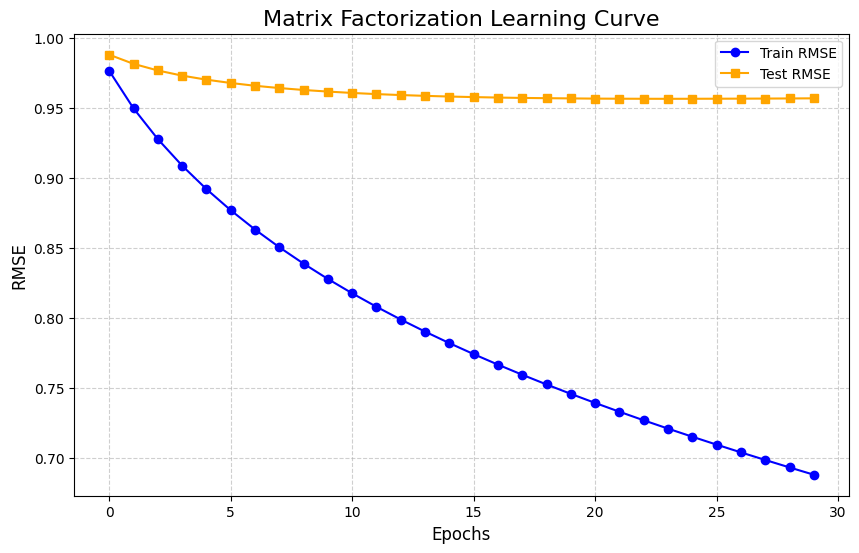

In [13]:
plot_learning_curve(mf_model.train_rmse_history, mf_model.test_rmse_history)

In [14]:
def show_recommendations_human_readable(user_idx, model, top_k=5):
    """
    Displays user history and model recommendations with denormalized ratings.
    """
    try:
        mean_path = os.path.join(PROCESSED_FOLDER, "mean_rating.npy")
        std_path = os.path.join(PROCESSED_FOLDER, "std_rating.npy")
        
        global_mean = np.load(mean_path)[0]
        global_std = np.load(std_path)[0]
        
    except FileNotFoundError:
        print("Error: Scaling files (mean/std) not found in processed folder.")
        global_mean = 0.0
        global_std = 1.0
        
    if user_idx not in inv_user_map:
        print("Error: User Index out of bounds.")
        return

    user_str_id = inv_user_map[user_idx]
    print(f"\nUser ID: {user_str_id} (Index: {user_idx})")
    
    # Ground Truth
    user_interactions = train_data[train_data[:, 0] == user_idx]
    
    sorted_interactions = user_interactions[np.argsort(user_interactions[:, 2])[::-1]]
    
    print(f"\n--- History: Top Liked Products ---")
    for i in range(min(5, len(sorted_interactions))):
        item_idx = int(sorted_interactions[i, 1])
        raw_rating = sorted_interactions[i, 2]
        # Unscale the rating
        unscaled_rating = (raw_rating * global_std) + global_mean
        
        product_str = inv_product_map.get(item_idx, "Unknown")
        
        print(f"Product: {product_str} | Rating: {unscaled_rating:.2f}")
        
    # Prediction
    rec_indices = model.recommend(user_idx, top_k=top_k)
    
    print(f"\n--- Recommendations: Top {top_k} Products ---")
    for i, item_idx in enumerate(rec_indices):
        product_str = inv_product_map.get(item_idx, "Unknown")
        
        # Predict score (Normalized)
        score = model.predict(user_idx, item_idx)
        
        # Unscale the predicted score
        unscaled_score = (score * global_std) + global_mean
        
        unscaled_score = min(5.0, max(1.0, unscaled_score))
        
        print(f"Rank {i+1}: Product {product_str} | Predicted: {unscaled_score:.2f}")

In [15]:
# Pick a user from test_data to see predictions
random_user_idx = int(np.random.choice(test_data[:, 0]))
show_recommendations_human_readable(random_user_idx, mf_model)


User ID: A2O6IC9KWY8TQR (Index: 9914)

--- History: Top Liked Products ---
Product: B002JSL6QI | Rating: 5.00
Product: B00B1DRA94 | Rating: 5.00
Product: B005XIM6J2 | Rating: 5.00
Product: B002DPUY4W | Rating: 5.00
Product: B00639DLV2 | Rating: 5.00

--- Recommendations: Top 5 Products ---
Rank 1: Product B006QV2XDY | Predicted: 4.30
Rank 2: Product B00AEEIL0I | Predicted: 4.30
Rank 3: Product B007RIEYGO | Predicted: 4.29
Rank 4: Product B00GCQMSVA | Predicted: 4.28
Rank 5: Product B005OZF1S2 | Predicted: 4.27
